## "Detection of Anomalies in Financial Transactions using Deep Autoencoder Networks"

This GPU Technology Conference (GTC) 2018 lab was developed by Mr. X, and Mr. Y

## 01. Environment Verification

#### 01.1 Python Verification

Before we begin, let's verify that Python is working on your system. To do this, execute the cell block below by giving it focus (clicking on it with your mouse), and hitting Shift-Enter, or pressing the play button in the toolbar above. If all goes well, you should see some output returned below the grey cell.

In [1]:
print('The answer should be forty-two: {}'.format(str(40+2)))

The answer should be forty-two: 42


#### 01.2 Import Python Libraries

In [2]:
# importing utilities
import os
from datetime import datetime
import matplotlib.pyplot as plt
%matplotlib inline

# importing pytorch libraries
import torch
from torch import nn
from torch import autograd
from torch.utils.data import DataLoader

# importing data science libraries
import pandas as pd
import random as rd
import numpy as np

#### 01.3 CUDNN / GPU Verficiation

In [3]:
# print CUDNN backend version
print('The CUDNN backend version: {}'.format(torch.backends.cudnn.version()))

The CUDNN backend version: None


Let's execute the cell below to display information about the GPUs running on the server.

In [4]:
!nvidia-smi

/bin/sh: nvidia-smi: command not found


Let's execute the cell below to display information about the PyTorch version running on the server.

In [5]:
# print current PyTorch version
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] PyTorch version: {}'.format(now, torch.__version__))

[LOG 20180125-08:49:19] PyTorch version: 0.3.0.post4


## 02. Lab Overview

ToDo -- Timur and Marco

<img align="middle" style="max-width: 550px; height: auto" src="images/accounting.png">

## 03. Autoencoder Neural Networks

#### 03.1 Introduction to Autoencoder Neural Networks

<img align="middle" style="max-width: 600px; height: auto" src="images/autoencoder.png">

#### 03.2 Implementing the Encoder Network

In [6]:
class encoder(nn.Module):

    def __init__(self):

        super(encoder, self).__init__()

        self.dropout = nn.Dropout(p=0.0, inplace=True)

        self.encoder_L1 = nn.Linear(401, 512, bias=True)
        nn.init.xavier_uniform(self.encoder_L1.weight)
        self.encoder_R1 = nn.LeakyReLU(negative_slope= 0.4, inplace=True)

        self.encoder_L2 = nn.Linear(512, 256, bias=True)
        nn.init.xavier_uniform(self.encoder_L2.weight)
        self.encoder_R2 = nn.LeakyReLU(negative_slope= 0.4, inplace=True)

        self.encoder_L3 = nn.Linear(256, 128, bias=True)
        nn.init.xavier_uniform(self.encoder_L3.weight)
        self.encoder_R3 = nn.LeakyReLU(negative_slope= 0.4, inplace=True)

        self.encoder_L4 = nn.Linear(128, 64, bias=True)
        nn.init.xavier_uniform(self.encoder_L4.weight)
        self.encoder_R4 = nn.LeakyReLU(negative_slope= 0.4, inplace=True)

        self.encoder_L5 = nn.Linear(64, 32, bias=True)
        nn.init.xavier_uniform(self.encoder_L5.weight)
        self.encoder_R5 = nn.LeakyReLU(negative_slope= 0.4, inplace=True)

        self.encoder_L6 = nn.Linear(32, 16, bias=True)
        nn.init.xavier_uniform(self.encoder_L6.weight)
        self.encoder_R6 = nn.LeakyReLU(negative_slope= 0.4, inplace=True)

        self.encoder_L7 = nn.Linear(16, 8, bias=True)
        nn.init.xavier_uniform(self.encoder_L7.weight)
        self.encoder_R7 = nn.LeakyReLU(negative_slope= 0.4, inplace=True)

        self.encoder_L8 = nn.Linear(8, 4, bias=True)
        nn.init.xavier_uniform(self.encoder_L8.weight)
        self.encoder_R8 = nn.LeakyReLU(negative_slope= 0.4, inplace=True)

        self.encoder_L9 = nn.Linear(4, 3, bias=True)
        nn.init.xavier_uniform(self.encoder_L9.weight)
        self.encoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    def forward(self, x):

        x = self.encoder_R1(self.dropout(self.encoder_L1(x)))
        x = self.encoder_R2(self.dropout(self.encoder_L2(x)))
        x = self.encoder_R3(self.dropout(self.encoder_L3(x)))
        x = self.encoder_R4(self.dropout(self.encoder_L4(x)))
        x = self.encoder_R5(self.dropout(self.encoder_L5(x)))
        x = self.encoder_R6(self.dropout(self.encoder_L6(x)))
        x = self.encoder_R7(self.dropout(self.encoder_L7(x)))
        x = self.encoder_R8(self.dropout(self.encoder_L8(x)))
        x = self.encoder_R9(self.encoder_L9(x))

        return x

#### 03.3 Implementing the Decoder Network

In [7]:
class decoder(nn.Module):

    def __init__(self):

        super(decoder, self).__init__()

        self.dropout = nn.Dropout(p=0.0, inplace=True)

        self.decoder_L1 = nn.Linear(3, 4, bias=True)
        nn.init.xavier_uniform(self.decoder_L1.weight)
        self.decoder_R1 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.decoder_L2 = nn.Linear(4, 8, bias=True)
        nn.init.xavier_uniform(self.decoder_L2.weight)
        self.decoder_R2 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.decoder_L3 = nn.Linear(8, 16, bias=True)
        nn.init.xavier_uniform(self.decoder_L3.weight)
        self.decoder_R3 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.decoder_L4 = nn.Linear(16, 32, bias=True)
        nn.init.xavier_uniform(self.decoder_L4.weight)
        self.decoder_R4 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.decoder_L5 = nn.Linear(32, 64, bias=True)
        nn.init.xavier_uniform(self.decoder_L5.weight)
        self.decoder_R5 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.decoder_L6 = nn.Linear(64, 128, bias=True)
        nn.init.xavier_uniform(self.decoder_L6.weight)
        self.decoder_R6 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.decoder_L7 = nn.Linear(128, 256, bias=True)
        nn.init.xavier_uniform(self.decoder_L7.weight)
        self.decoder_R7 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.decoder_L8 = nn.Linear(256, 512, bias=True)
        nn.init.xavier_uniform(self.decoder_L8.weight)
        self.decoder_R8 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

        self.decoder_L9 = nn.Linear(512, 401, bias=True)
        nn.init.xavier_uniform(self.decoder_L9.weight)
        self.decoder_R9 = nn.LeakyReLU(negative_slope=0.4, inplace=True)

    def forward(self, x):

        x = self.decoder_R1(self.dropout(self.decoder_L1(x)))
        x = self.decoder_R2(self.dropout(self.decoder_L2(x)))
        x = self.decoder_R3(self.dropout(self.decoder_L3(x)))
        x = self.decoder_R4(self.dropout(self.decoder_L4(x)))
        x = self.decoder_R5(self.dropout(self.decoder_L5(x)))
        x = self.decoder_R6(self.dropout(self.decoder_L6(x)))
        x = self.decoder_R7(self.dropout(self.decoder_L7(x)))
        x = self.decoder_R8(self.dropout(self.decoder_L8(x)))
        x = self.decoder_R9(self.decoder_L9(x))
        
        return x

In [8]:
# init training network classes / architectures
encoder_train = encoder()
decoder_train = decoder()

# push to cuda if cudnn is available
if (torch.backends.cudnn.version() != None):
    encoder_train = encoder().cuda()
    decoder_train = decoder().cuda()

In [9]:
# print the initialized architectures
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] encoder architecture:\n\n{}\n'.format(now, encoder_train))
print('[LOG {}] decoder architecture:\n\n{}\n'.format(now, decoder_train))

[LOG 20180125-08:49:19] encoder architecture:

encoder(
  (dropout): Dropout(p=0.0, inplace)
  (encoder_L1): Linear(in_features=401, out_features=512)
  (encoder_R1): LeakyReLU(0.4, inplace)
  (encoder_L2): Linear(in_features=512, out_features=256)
  (encoder_R2): LeakyReLU(0.4, inplace)
  (encoder_L3): Linear(in_features=256, out_features=128)
  (encoder_R3): LeakyReLU(0.4, inplace)
  (encoder_L4): Linear(in_features=128, out_features=64)
  (encoder_R4): LeakyReLU(0.4, inplace)
  (encoder_L5): Linear(in_features=64, out_features=32)
  (encoder_R5): LeakyReLU(0.4, inplace)
  (encoder_L6): Linear(in_features=32, out_features=16)
  (encoder_R6): LeakyReLU(0.4, inplace)
  (encoder_L7): Linear(in_features=16, out_features=8)
  (encoder_R7): LeakyReLU(0.4, inplace)
  (encoder_L8): Linear(in_features=8, out_features=4)
  (encoder_R8): LeakyReLU(0.4, inplace)
  (encoder_L9): Linear(in_features=4, out_features=3)
  (encoder_R9): LeakyReLU(0.4, inplace)
)

[LOG 20180125-08:49:19] decoder archit

## 04. Financial Fraud Detection Dataset

ToDo -- Timur

In [10]:
# import original and encoded transactions
ori_dataset = pd.read_csv("./data/transactions.csv", sep=",", header=0, encoding="utf-8")
enc_dataset = pd.read_csv("./data/enc_transactions.csv", sep=",", header=0, encoding="utf-8").astype(float)

now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print("[LOG {}] encoded transactions of shape [{}/{}] imported".format(str(now), str(enc_dataset.shape[0]), str(enc_dataset.shape[1])))

torch_dataset = torch.from_numpy(enc_dataset.values).float()

[LOG 20180125-08:49:39] encoded transactions of shape [307457/401] imported


In [11]:
ori_dataset.head(10)

,ID_Key,Mapping_Key,NetValueInDocumentCurrency,TaxAmountInDocumentCurrency,ProductCode_Key,AccountID_Key,CurrencyCode_Key,TaxCode_Key,CompanyKey_Key,ShipToCountry_Key,ShipFromCountry_Key,CustomerID_ShipTo_Key,CustomerID_BillTo_Key,Artifical_Outlier,Reconstruction_Error
0,1,NaN,999999.0,50000.0000,Aplha,Bravo,Tango,Fruti,Kenya,India,Anant,Marco,Bermuda,1,NaN
1,2,NaN,598434.0,88000.0000,Zori,Account,Categorical,Python,Indonesia,details,?ro7ekt,placed,SOurdf,1,NaN
2,3,NaN,450864.0,70005.0000,Author,Book,What??,DUH!!,I,Hate,these,Anamolies,Detection,1,NaN
3,4,NaN,108888.0,28000.0000,top,what!,AyCaramba!,PwC,FTS,=Great,Maybe?,Artificial,Outliers,1,NaN
4,5,NaN,233355.0,4514.5617,Java,Progrramming,Sucks,really.,Go,Kalrsruhe!,I,am,dumb,1,NaN
5,6,NaN,44348.0,2691.0000,Stuttgart/Karlsruhe,(pm/rl),Die,Forscher,Johannes,Gescher,und,Katrin,Klink,1,NaN
6,7,NaN,265100.0,4083.0000,Für,die,Ausschreibung,„Fellowships,für,Innovationen,in,der,Hochschullehre“,1,NaN
7,8,NaN,102940.0,2026.0000,Christoph,"Dahl,",Geschäftsführer,der,Baden-Württemberg,"Stiftung,",lobte,die,Arbeit,1,NaN
8,9,NaN,104639.0,4137.0000,vom,Karlsruher,Institut,für,Technologie,(KIT),sind,für,ihre,1,NaN
9,10,NaN,815721.0,2806.0000,der,Baden-Württemberg,Stiftung,sind,rund,120,Anträge,eingegangen.,Aus,1,NaN


In [12]:
features = ["AccountID_Key", "CurrencyCode_Key", "TaxCode_Key", "CompanyKey_Key", "ShipToCountry_Key", "ShipFromCountry_Key"]
ranges = [0, 62+1, 121+1, 183+1, 234+1, 349+1, 400+1]

# init training results
columns = ["timestamp", "node", "seed", "architecture", "epoch", "rec_loss", "roc_auc", "anomalies", "normalies", "anomalies_s", "normalies_s", "max_threshold", "max_tpr_s", "max_fpr_s", "precision", "recall", "f1_score", "fpr", "tpr", "thresholds"]
evaluations = ["err_" + str(element) for element in range(0, (len(features))+1)]
columns.extend(evaluations)
evaluations = ["ano_c1_" + str(element) for element in range(0, (len(features))+1)]
columns.extend(evaluations)
evaluations = ["ano_c2_" + str(element) for element in range(0, (len(features))+1)]
columns.extend(evaluations)
evaluation_results = pd.DataFrame(columns=columns)

## 05. Network Training

ToDo - Timur and Marco

In [13]:
# init deterministic seed
seed_value = 1234 #4444 #3333 #2222 #1111 #1234
rd.seed(seed_value) # set random seed
np.random.seed(seed_value) # set numpy seed
torch.manual_seed(seed_value) # set pytorch seed CPU
torch.cuda.manual_seed(seed_value) # set pytorch seed GPU

# init training parameters
num_epochs = 10
mini_batch_size = 128
learning_rate = 1e-3

# convert to pytorch tensor - none cuda enabled
dataloader = DataLoader(torch_dataset, batch_size=mini_batch_size, shuffle=True, num_workers=0)
# set num_workers to zero to retreive deterministic results

# determine if CUDA is available at compute node
if (torch.backends.cudnn.version() != None):

    dataloader = DataLoader(torch_dataset.cuda(), batch_size=mini_batch_size, shuffle=True)

# define optimization criterion and optimizer
criterion = nn.BCEWithLogitsLoss()
encoder_optimizer = torch.optim.Adam(encoder_train.parameters(), lr=learning_rate)
decoder_optimizer = torch.optim.Adam(decoder_train.parameters(), lr=learning_rate)

# train autoencoder model
for epoch in range(num_epochs):

    # init mini batch counter
    mini_batch_count = 0

    # determine if CUDA is available at compute node
    if (torch.backends.cudnn.version() != None) and (use_cuda == True):

        # set all networks / models in CPU mode
        encoder_train.cuda()
        decoder_train.cuda()

    # set networks in training mode (apply dropout when needed)
    encoder_train.train()
    decoder_train.train()

    for mini_batch_data in dataloader:

        # increase mini batch counter
        mini_batch_count += 1

        # convert mini batch to torch variable
        mini_batch_torch = autograd.Variable(mini_batch_data)

        # =================== forward pass =====================

        # run forward pass
        z_representation = encoder_train(mini_batch_torch) # encode mini-batch data
        mini_batch_reconstruction = decoder_train(z_representation) # decode mini-batch data

        # determine reconstruction loss
        reconstruction_loss = criterion(mini_batch_reconstruction, mini_batch_torch)

        # =================== backward pass ====================

        # reset graph gradients
        decoder_optimizer.zero_grad()
        encoder_optimizer.zero_grad()

        # run backward pass
        reconstruction_loss.backward()

        # update network parameters
        decoder_optimizer.step()
        encoder_optimizer.step()

        # =================== log ==============================

        if mini_batch_count % 100 == 0:

            # print mini batch reconstuction results
            now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
            print('[LOG {}] training status, epoch: [{:04}/{:04}], batch: {:04}, loss: {:.10f}'.format(now, (epoch+1), num_epochs, mini_batch_count, reconstruction_loss.data[0]))

    # save trained encoder model file to disk
    now = datetime.utcnow().strftime("%Y%m%d-%H_%M_%S")
    encoder_model_name = "{}_ep_{}_encoder_model.pth".format(now, (epoch+1))
    torch.save(encoder_train.state_dict(), os.path.join("models", encoder_model_name))

    # save trained decoder model file to disk
    decoder_model_name = "{}_ep_{}_decoder_model.pth".format(now, (epoch+1))
    torch.save(decoder_train.state_dict(), os.path.join("models", decoder_model_name))

[LOG 20180125-08_49_45] training status, epoch: [0001/0010], batch: 0100, loss: 0.0274375156
[LOG 20180125-08_49_49] training status, epoch: [0001/0010], batch: 0200, loss: 0.0174645148
[LOG 20180125-08_49_52] training status, epoch: [0001/0010], batch: 0300, loss: 0.0082735242
[LOG 20180125-08_49_55] training status, epoch: [0001/0010], batch: 0400, loss: 0.0069946530
[LOG 20180125-08_49_58] training status, epoch: [0001/0010], batch: 0500, loss: 0.0053769667
[LOG 20180125-08_50_01] training status, epoch: [0001/0010], batch: 0600, loss: 0.0069966190
[LOG 20180125-08_50_04] training status, epoch: [0001/0010], batch: 0700, loss: 0.0053451452
[LOG 20180125-08_50_07] training status, epoch: [0001/0010], batch: 0800, loss: 0.0035927675
[LOG 20180125-08_50_11] training status, epoch: [0001/0010], batch: 0900, loss: 0.0029478113
[LOG 20180125-08_50_15] training status, epoch: [0001/0010], batch: 1000, loss: 0.0028416477
[LOG 20180125-08_50_19] training status, epoch: [0001/0010], batch: 11

## 06. Result Evaluation

In [14]:
# specify trained models to be loaded
#encoder_model_name = "20180125-06_44_14_ep_1_encoder_model.pth"
#decoder_model_name = "20180125-06_44_14_ep_1_decoder_model.pth"

# init training network classes / architectures
encoder_eval = encoder()
decoder_eval = decoder()

# load trained models
encoder_eval.load_state_dict(torch.load(os.path.join("models", encoder_model_name)))
decoder_eval.load_state_dict(torch.load(os.path.join("models", decoder_model_name)))

In [15]:
# convert encoded transactional data to torch Variable
data = autograd.Variable(torch_dataset)

# set networks in training mode (don't apply dropout)
encoder_eval.eval()
decoder_eval.eval()

# reconstruct encoded transactional data
reconstruction = decoder_eval(encoder_eval(data))

In [16]:
# determine reconstruction loss - all transactions
reconstruction_loss_all = criterion(reconstruction, data)

# print reconstruction loss - all transactions
now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
print('[LOG {}] collected reconstruction loss of: {:06}/{:06} transactions'.format(now, reconstruction.size()[0], reconstruction.size()[0]))
print('[LOG {}] reconstruction loss: {:.10f}'.format(now, reconstruction_loss_all.data[0]))

[LOG 20180125-09:07:16] collected reconstruction loss of: 307457/307457 transactions
[LOG 20180125-09:07:16] reconstruction loss: 0.0003191435


In [17]:
# init binary cross entropy errors
reconstruction_loss_transaction = np.zeros(reconstruction.size()[0])

# iterate over all detailed reconstructions
for i in range(0, reconstruction.size()[0]):

    # determine reconstruction loss - individual transactions
    reconstruction_loss_transaction[i] = criterion(reconstruction[i], data[i])

    if(i % 100000 == 0):

        ### print conversion summary
        now = datetime.utcnow().strftime("%Y%m%d-%H:%M:%S")
        print('[LOG {}] collected individial reconstruction loss of: {:06}/{:06} transactions'.format(now, i, reconstruction.size()[0]))

[LOG 20180125-09:07:16] collected individial reconstruction loss of: 000000/307457 transactions
[LOG 20180125-09:07:28] collected individial reconstruction loss of: 100000/307457 transactions
[LOG 20180125-09:07:38] collected individial reconstruction loss of: 200000/307457 transactions
[LOG 20180125-09:07:49] collected individial reconstruction loss of: 300000/307457 transactions


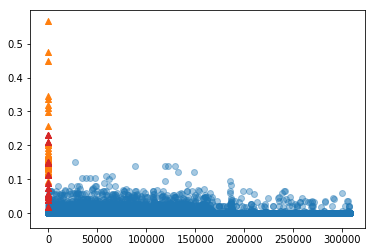

In [20]:
# prepare plot
fig = plt.figure()
ax = fig.add_subplot(111)

labels = np.array(ori_dataset.Artifical_Outlier)
ids = np.array(ori_dataset.ID_Key, ori_dataset.Artifical_Outlier)

regular_x = ids[np.where(labels==0)]
regular_y = reconstruction_loss_transaction[np.where(labels==0)]

# plot error scatter plot
ax.scatter(regular_x, regular_y, c='C0', alpha=0.4, marker="o") # plot regular transactions

anomaly_1_x = ids[np.where(labels==1)]
anomaly_1_y = reconstruction_loss_transaction[np.where(labels==1)]

# plot error scatter plot
ax.scatter(anomaly_1_x, anomaly_1_y, c='C1', marker="^") # plot regular transactions

anomaly_2_x = ids[np.where(labels==2)]
anomaly_2_y = reconstruction_loss_transaction[np.where(labels==2)]

# plot error scatter plot
ax.scatter(anomaly_2_x, anomaly_2_y, c='C3', marker="^") # plot regular transactions

## 07. Optional Excercises

ToDo - Timur and Marco

## 08. Lab Summary

ToDo - Timur and Marco

## 09. Next Steps

ToDo - Timur and Marco